In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
import h5py
import numpy as np
from astropy.units import deg
#from lenstools import GaussianNoiseGenerator, ConvergenceMap
from scipy.ndimage import gaussian_filter

I noticed that the results here strongly depend on the normalization and they don't totally agree, so i want to try to understand that. 

In [17]:
smooth = 1.0
shape_noise= 0.29
data_mod1 = lambda x: np.log10(gaussian_filter(x+np.random.randn(*x.shape)*shape_noise, smooth)+1.0) # add a normalization, hopefully sufficient
data_mod2 = lambda x: gaussian_filter(x+np.random.randn(*x.shape)*shape_noise, smooth)
data_mod3 = lambda x: 10**x-1 #undo part of mod1

In [18]:
orig_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTraining.hdf5'
grf_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTrainingGRF_smooth_1.0_noise_0.3.hdf5'
clone_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTrainingRobustifyDeepResnetRegAdvWhiteNoise1.0.hdf5'
#clone_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTrainingRobustifyDeepResnetRegAdvGRFNoise1.0.hdf5'

In [19]:
def compute_norm(fname, data_mod= lambda x:x):
    val_sum, N = 0,0
    N_boxes = 10
    with h5py.File(fname, 'r') as f:
        for boxno in f.keys():
            if int(boxno[-3:])>N_boxes:
                break
            print(boxno,)
            X = f[boxno]['X'][()].squeeze()

            X= np.array([data_mod(x) for x in X])
            print(X.std())
                
            val_sum+=X.sum()
            N+=np.prod(X.shape)
            
        mu = val_sum/float(N)
        val_sum=0
        print(N)
        for boxno in f.keys():
            if int(boxno[-3:])>N_boxes:
                break
                #print(boxno)
            print(boxno,)

            X = f[boxno]['X'][()].squeeze()
            X= np.array([data_mod(x) for x in X])
            val_sum+=((X-mu)**2).sum()
            
        std = np.sqrt(val_sum/N)
        
    return mu, std, X

In [20]:
orig_mu, orig_std, ex_X = compute_norm(orig_fname, data_mod = data_mod2)

Box000
0.08244436978211875
Box001
0.08240624146070552
Box002
0.08238899805643253
Box003
0.08239347630459826
Box004
0.08246630480752873
Box005
0.08238357424933886
Box006
0.08246898794419094
Box007
0.08243275247829272
Box008
0.08243410175009482
Box009
0.08239044226864269
Box010
0.08249467284048696
934281216
Box000
Box001
Box002
Box003
Box004
Box005
Box006
Box007
Box008
Box009
Box010


In [21]:
orig_mu, orig_std

(-1.6915041212763955e-05, 0.08243651063574976)

In [22]:
clone_mu, clone_std, ex_X = compute_norm(clone_fname, data_mod = data_mod3)

Box000
0.009416709
Box001
0.008922472
Box002
0.008926332
Box003
0.008801705
Box004
0.010370793
Box005
0.008933678
Box006
0.010309065
Box007
0.009312823
Box008
0.009527951
Box009
0.008571801
Box010
0.010472423
934281216
Box000
Box001
Box002
Box003
Box004
Box005
Box006
Box007
Box008
Box009
Box010


In [23]:
clone_mu, clone_std# = -0.0007, 0.01

(-0.00048315635433903445, 0.009445551150378864)

In [43]:
compute_norm(grf_fname, data_mod = data_mod3)

Box000
0.00705689104887334
Box001
0.006678298572704739
Box002
0.006660553744847391
Box003
0.006650149034889863
Box004
0.00752386304402796
Box005
0.006673921778922321
Box006
0.00751998229574665
Box007
0.007002143700682096
Box008
0.00713163371903387
Box009
0.006479423514830955
Box010
0.007575869337940683
934281216
Box000
Box001
Box002
Box003
Box004
Box005
Box006
Box007
Box008
Box009
Box010


(-2.5241152763627533e-06,
 0.00700619440347421,
 array([[[ 8.76983747e-03,  3.82597492e-03, -1.06738945e-03, ...,
           1.00857861e-02,  1.08411390e-02,  1.19630412e-02],
         [ 8.39334550e-03,  5.41725199e-03,  2.32147149e-03, ...,
           6.68883926e-03,  8.05271296e-03,  1.08444733e-02],
         [ 4.77905922e-03,  4.17908482e-03,  3.42966566e-03, ...,
           4.11389632e-03,  4.49024562e-03,  5.95781592e-03],
         ...,
         [ 1.39328225e-02,  1.06267478e-02,  4.49127035e-03, ...,
           1.50259017e-02,  1.08753149e-02,  1.10088439e-02],
         [ 1.05368749e-02,  5.99662415e-03, -8.38798304e-04, ...,
           1.34560759e-02,  1.00547250e-02,  9.28005647e-03],
         [ 7.53636475e-03,  2.62300380e-03, -3.66961691e-03, ...,
           1.23236281e-02,  1.14735785e-02,  9.31590273e-03]],
 
        [[ 8.56441484e-03,  3.53184184e-03, -1.47823697e-03, ...,
           9.64300603e-03,  1.03534632e-02,  1.16018951e-02],
         [ 8.22868763e-03,  5.20625235e

In [40]:
def plot_set(orig_fname, grf_fname, clone_fname, boxno, idx):
    fig = plt.figure(figsize=(18,6))
    with h5py.File(orig_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        X1 = f[boxno]['X'][idx, :].squeeze()
        X1 = data_mod2(X1)
        #print(X1.std())
        #X= f[boxno]['X'][()].squeeze()
        #X1 = (X1-orig_mu)/orig_std
        
        
    with h5py.File(grf_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        X2 = f[boxno]['X'][idx, :].squeeze()
        X2 = data_mod3(X2)
        #X2 = (X2-mean)/std
        
    with h5py.File(clone_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        X3 = f[boxno]['X'][idx, :].squeeze()

        X3 = data_mod3(X3)
        #print(X3.std())
        #print(X3.std())
        X3 = ((X3-clone_mu)/clone_std)*orig_std+orig_mu
        #print(X3.std())

        #X2 = (X2-mean)/std
    #print(X1.mean(), X3.mean())
    #print(X1.std(), X3.std())
    plt.subplot(131)
    plt.imshow(X1, vmin=-0.3, vmax=0.3)
    plt.subplot(132)
    plt.imshow(X2)
    plt.subplot(133)
    plt.imshow(X3,vmin=-0.3, vmax=0.3)
    plt.show()
    return X1,X3

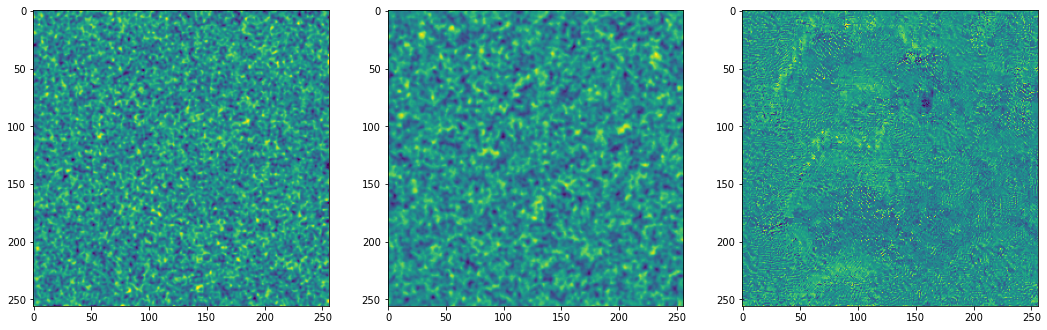

In [41]:
X1, X3 = plot_set(orig_fname,grf_fname, clone_fname, 'Box021', 122)

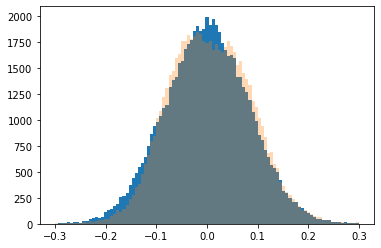

In [42]:
bins = np.linspace(-0.3, 0.3, 100)
plt.hist(X1.flatten(), bins = bins);
plt.hist(X3.flatten(), bins = bins, alpha = 0.3);